In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

np.random.seed(17)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
%cd /content/drive/Shareddrives/Deep Learning Project/Project/data

/content/drive/Shareddrives/Deep Learning Project/Project/data


In [19]:
sp = pd.read_csv("SPX_2.csv")
sp["Date"] = pd.to_datetime(sp['Date'])
sp = sp[['Date','Open','High','Low','Close']]
sp = sp.sort_values('Date', ascending=True)
start_date = pd.to_datetime('1980-01-01')
sp = sp[sp['Date'] >= start_date]
sp_df = sp[['Open','High','Low','Close']]

In [20]:
tf.__version__

'2.15.0'

In [21]:
train_size = int(len(sp) * 0.85)
train_df, test_df = sp.iloc[:train_size], sp.iloc[train_size:]

print(train_df.shape,test_df.shape)

(8755, 5) (1546, 5)


In [22]:
train = train_df.copy()
test = test_df.copy()

In [23]:
train_df = train_df[['Date','Close']]
test_df = test_df[['Date','Close']]

In [24]:
# Normalize the numerical data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
# scaler = StandardScaler()

train_num_cols = train_df.columns.difference(['Date'])
test_num_cols = test_df.columns.difference(['Date'])

train_df[train_num_cols] = scaler.fit_transform(train_df[train_num_cols])
test_df[test_num_cols] = scaler.transform(test_df[test_num_cols])

In [25]:
train

,Date,Open,High,Low,Close
13022,1980-01-02,107.940002,108.430000,105.290001,105.760002
13023,1980-01-03,105.760002,106.080002,103.260002,105.220001
13024,1980-01-04,105.220001,107.080002,105.089996,106.519997
13025,1980-01-07,106.519997,107.800003,105.800003,106.809998
13026,1980-01-08,106.809998,109.290001,106.290001,108.949997
...,...,...,...,...,...
21772,2014-09-10,1988.410034,1996.660034,1982.989990,1995.689941
21773,2014-09-11,1992.849976,1997.650024,1985.930054,1997.449951
21774,2014-09-12,1996.739990,1996.739990,1980.260010,1985.540039
21775,2014-09-15,1986.040039,1987.180054,1978.479980,1984.130005


In [26]:
sequence_length = 10

# Prepare sequences of data for training
def create_sequences(data, dates, sequence_length):
    sequences = []
    targets = []
    sequence_dates= []
    # seq and targets the same
    for i in range(0, len(data) - sequence_length+1, sequence_length):
        sequences.append(data[i: i + sequence_length])
        targets.append(data[i: i + sequence_length])
        sequence_dates.append(dates[i + sequence_length - 1])
    return np.array(sequences), np.array(targets), np.array(sequence_dates)

train_data = train_df[train_num_cols].values
test_data = test_df[test_num_cols].values
train_dates = train_df['Date'].values
test_dates = test_df['Date'].values

X_train, y_train, train_seq_dates = create_sequences(train_data, train_dates, sequence_length)
X_test, y_test, test_seq_dates = create_sequences(test_data, test_dates, sequence_length)

In [27]:
X_train.shape

(875, 10, 1)

In [28]:
def build_lstm_autoencoder(input_shape):
    # Encoder
    inputs = keras.Input(shape=input_shape)
    encoder_lstm1 = layers.LSTM(128, activation='relu', return_sequences=True)(inputs)
    encoder_lstm2 = layers.LSTM(64, activation='relu', return_sequences=False, name='encode_out')(encoder_lstm1)

    # Latent representation
    repeat_vector = layers.RepeatVector(sequence_length,name='repeat_vec')(encoder_lstm2)

    # # Decoder1
    # decoder_lstm1 = layers.LSTM(64, activation='relu', return_sequences=True)(repeat_vector)
    # attention_output, attention_score = layers.Attention(name='attention_scores')([decoder_lstm1, repeat_vector], return_attention_scores=True)
    # decoder_lstm2 = layers.LSTM(128, activation='relu', return_sequences=True)(attention_output)

    # decoder 2
    decoder_lstm1 = layers.LSTM(64, activation='relu', return_sequences=True)(repeat_vector)
    attention_output1 = layers.Attention()([decoder_lstm1, repeat_vector])
    decoder_lstm2 = layers.LSTM(128, activation='relu', return_sequences=True)(attention_output1)


    # attention_output, attention_score = layers.Attention(name='attention_scores')([decoder_lstm2, encoder_lstm1],return_attention_scores=True)
    # Output layer
    outputs = layers.TimeDistributed(layers.Dense(1), name='output_sequence')(decoder_lstm2)

    # Attention
    attention_output, attention_score = layers.Attention(name='attention_scores')([decoder_lstm2, encoder_lstm1],return_attention_scores=True)



    model = keras.Model(inputs=inputs, outputs=[outputs,attention_score,encoder_lstm2])
    # model.compile(optimizer='adam', loss='mse')
    model.compile(optimizer='adam', loss={'output_sequence':'mse','attention_scores':None,'encode_out':None},
                  metrics={'output_sequence':'mse','attention_scores':None,'encode_out':None})

    return model

# # Set sequence length and num_features as appropriate
# sequence_length = 10
# num_features = 1
# input_shape = (sequence_length, num_features)

# # Build the model
# model2 = build_lstm_autoencoder(input_shape, sequence_length, num_features)

# # Print model summary
# model2.summary()
input_shape = (sequence_length, len(train_num_cols))
model = build_lstm_autoencoder(input_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 lstm_3 (LSTM)               (None, 10, 128)              66560     ['input_2[0][0]']             
                                                                                                  
 encode_out (LSTM)           (None, 64)                   49408     ['lstm_3[0][0]']              
                                                                                                  
 repeat_vec (RepeatVector)   (None, 10, 64)               0         ['encode_out[0][0]']          
                                                                                            

In [29]:

history=model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, shuffle=False)

# dummy_attention_data = np.zeros((len(X_train), sequence_length, 10, 10))  # shape must match the attention scores' output
# history = model.fit(X_train, [y_train], epochs=10, batch_size=32, validation_split=0.1,shuffle=False)

Epoch 1/10
50/50 [==============================] - 8s 45ms/step - loss: 0.0077 - output_sequence_loss: 0.0077 - output_sequence_mse: 0.0077 - val_loss: 0.0664 - val_output_sequence_loss: 0.0664 - val_output_sequence_mse: 0.0664
Epoch 2/10
50/50 [==============================] - 2s 31ms/step - loss: 0.0360 - output_sequence_loss: 0.0360 - output_sequence_mse: 0.0360 - val_loss: 0.0281 - val_output_sequence_loss: 0.0281 - val_output_sequence_mse: 0.0281
Epoch 3/10
50/50 [==============================] - 2s 33ms/step - loss: 0.0199 - output_sequence_loss: 0.0199 - output_sequence_mse: 0.0199 - val_loss: 0.0031 - val_output_sequence_loss: 0.0031 - val_output_sequence_mse: 0.0031
Epoch 4/10
50/50 [==============================] - 2s 32ms/step - loss: 0.0044 - output_sequence_loss: 0.0044 - output_sequence_mse: 0.0044 - val_loss: 0.0014 - val_output_sequence_loss: 0.0014 - val_output_sequence_mse: 0.0014
Epoch 5/10
50/50 [==============================] - 2s 42ms/step - loss: 0.0014 - ou

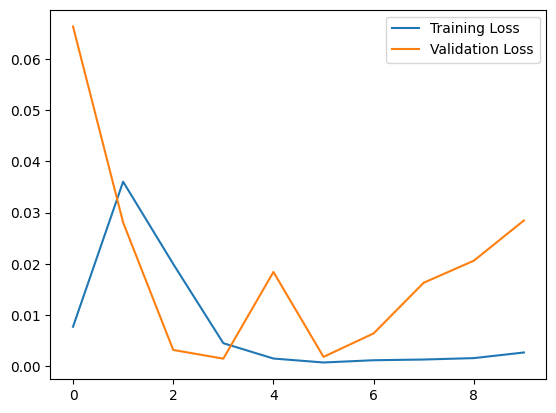

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();


In [31]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 32ms/step - loss: 1.7437 - output_sequence_loss: 1.7437 - output_sequence_mse: 1.7437


[1.7436907291412354, 1.7436907291412354, 1.7436907291412354]

In [32]:
!ls

anon_window.png  non_anon_window.png  saved_models     SPX_2.csv
images		 saved_model	      sp500_index.csv  spx.csv


In [33]:
# test_seq_dates
model.save('saved_models/final_model_4_attentions')

5/5 [==============================] - 1s 14ms/step


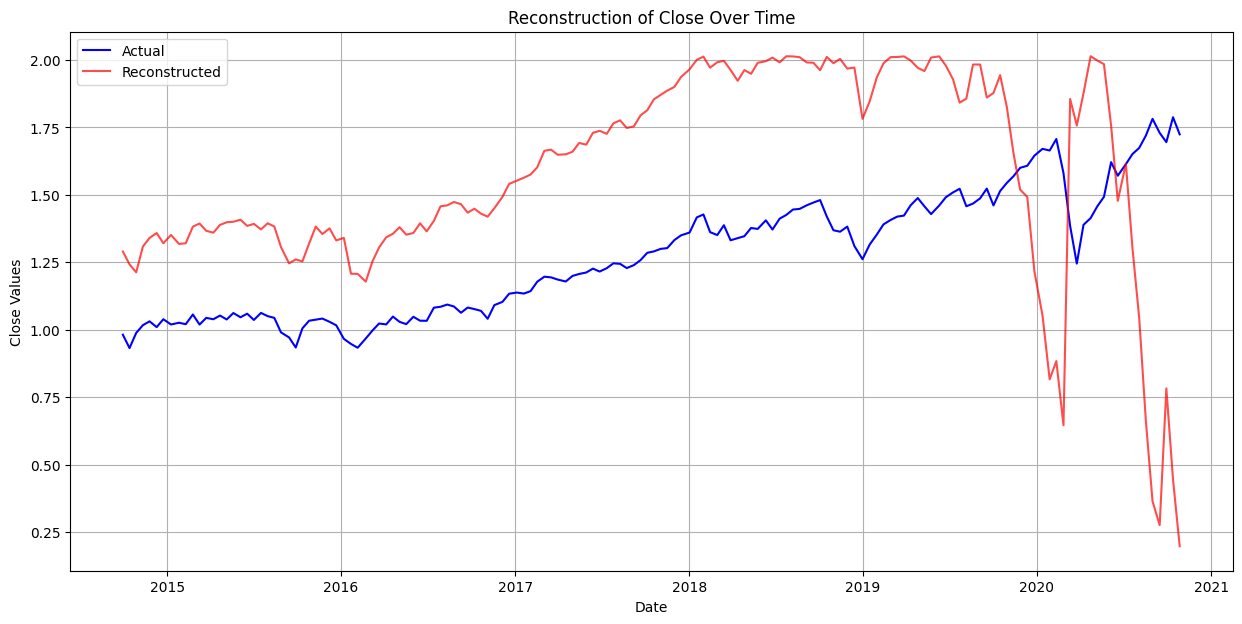

In [34]:
def plot_reconstruction_over_time(dates, actual, reconstructed, feature_index, feature_name):
    plt.figure(figsize=(15, 7))
    actual_plot = actual[:, -1, feature_index]
    reconstructed_plot = reconstructed[:, -1, feature_index]
    plt.plot(dates, actual_plot, label='Actual', color='blue')
    plt.plot(dates, reconstructed_plot, label='Reconstructed', color='red', alpha=0.7)
    plt.title(f'Reconstruction of {feature_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'{feature_name} Values')
    plt.legend()
    plt.grid(True)
    plt.show()



reconstructions, scores, encode = model.predict(X_test)

plot_reconstruction_over_time(test_seq_dates, y_test, reconstructions, feature_index=0, feature_name='Close')

In [35]:
# encode.shape

5/5 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


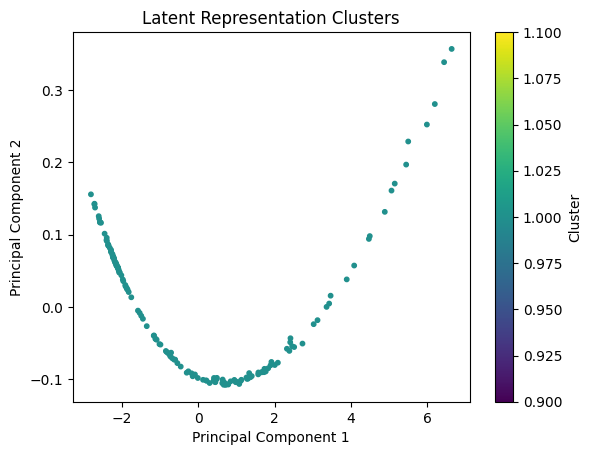

In [36]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

encoder_model = keras.Model(inputs=model.input, outputs=model.get_layer('encode_out').output)

latent_representation_train = encoder_model.predict(X_train)
latent_representation_test = encoder_model.predict(X_test)

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(latent_representation_train)
clusters = kmeans.predict(latent_representation_test)

pca = PCA(n_components=2)
latent_representation_pca = pca.fit_transform(latent_representation_test)

# Plot the clusters
plt.scatter(latent_representation_pca[:, 0], latent_representation_pca[:, 1], c=clusters, cmap='viridis', s=10)
plt.title('Latent Representation Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [37]:
latent_representation_test.shape

(154, 64)

In [38]:
# np.where(anomalies)

In [39]:
# reconstructions, scores = model.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=(1,2))

# threshold
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies in test
anomalies = reconstruction_errors > threshold
print("Detected anomalies:", np.where(anomalies)[0])

Detected anomalies: [134 136 148 149 150 151 152 153]


In [40]:
anomal = (np.where(anomalies)[0]/10).astype(int) # get the batch of the anomalies

In [41]:
len(latent_representation_test)

154

13
14
15


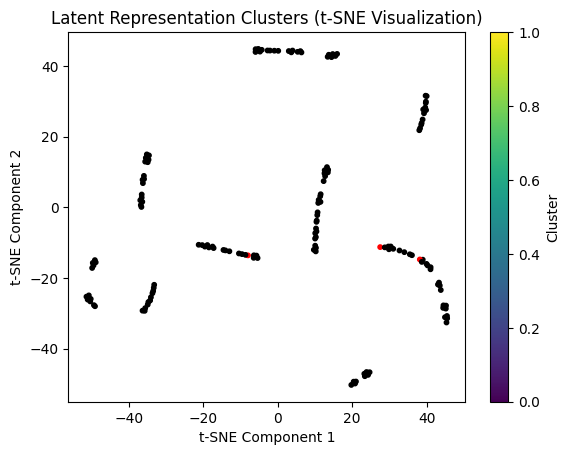

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, learning_rate=200, random_state=42)
latent_representation_tsne = tsne.fit_transform(latent_representation_test)
col =[]

for i in range(0, len(latent_representation_tsne)):
  if i in anomal:
    print(i)
    col.append('red')
  else:
    col.append('black')


plt.scatter(latent_representation_tsne[:, 0], latent_representation_tsne[:, 1], c=col, s=10)
plt.title('Latent Representation Clusters (t-SNE Visualization)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [43]:
# attention_scores

In [44]:
# X_train_pred, attention_scores = model.predict(X_train)
# plot_attention_weights(X_train, attention_scores)
# train_mse_loss = pd.DataFrame(np.mean(np.abs(X_train_pred[45]-X_train[45]), axis=1),columns=['Error'])

X_test_pred, attention_scores, _ = model.predict(X_test)
# plot_attention_weights(X_test_pred, attention_scores)
# test_mse_loss = pd.DataFrame(np.mean(np.square(X_test_pred[136]-X_test[136]), axis=1),columns=['Error'])

5/5 [==============================] - 0s 40ms/step


In [45]:
scores.shape

(154, 10, 10)

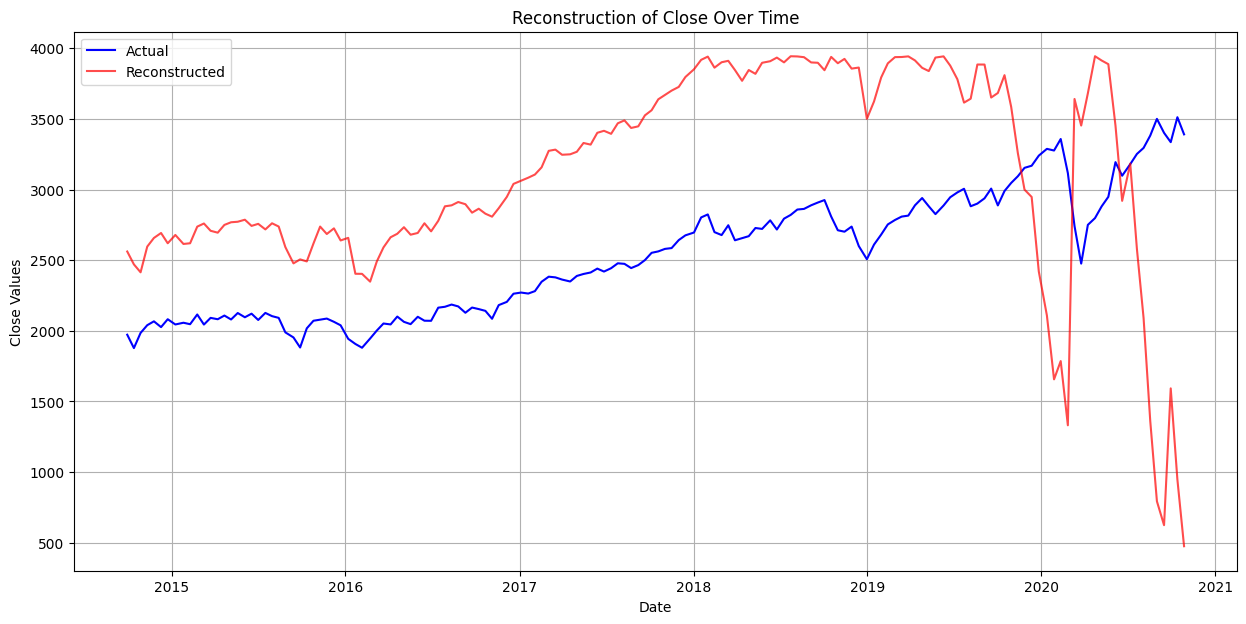

In [46]:
X_test_inverse = scaler.inverse_transform(X_test.reshape(-1, X_test.shape[2]))
reconstructions_inverse = scaler.inverse_transform(reconstructions.reshape(-1, reconstructions.shape[2]))

# fix shaping
X_test_inverse = X_test_inverse.reshape(X_test.shape)
reconstructions_inverse = reconstructions_inverse.reshape(reconstructions.shape)

def plot_reconstruction_over_time(dates, actual, reconstructed, feature_index, feature_name):
    plt.figure(figsize=(15, 7))
    actual_plot = actual[:, -1, feature_index]
    reconstructed_plot = reconstructed[:, -1, feature_index]
    plt.plot(dates, actual_plot, label='Actual', color='blue')
    plt.plot(dates, reconstructed_plot, label='Reconstructed', color='red', alpha=0.7)
    plt.title(f'Reconstruction of {feature_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'{feature_name} Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# reconstructions = model.predict(X_test)
plot_reconstruction_over_time(test_seq_dates, X_test_inverse, reconstructions_inverse, feature_index=0, feature_name='Close')

In [47]:
# # Predict on train data
# reconstructions, scores = model.predict(X_test)
# reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=(1,2))

# # threshold
# threshold = np.percentile(reconstruction_errors, 95)

# # Identify anomalies in test
# anomalies = reconstruction_errors > threshold
# print("Detected anomalies:", np.where(anomalies)[0])

In [48]:
rec2 = reconstructions_inverse.reshape((1540,))
x_test2 = X_test_inverse.reshape((1540,))
# len(rec2)
len(x_test2)

1540

In [49]:
rec2

array([ 3235.7866 ,  2233.8115 ,  2654.9314 , ...,   376.10696,
       11770.705  ,   475.0295 ], dtype=float32)

In [50]:
x_test2

array([2001.569946, 2011.359985, 2010.400024, ..., 3465.389893,
       3400.969971, 3390.679932])

In [51]:
X_test_inverse

array([[[2001.569946],
        [2011.359985],
        [2010.400024],
        ...,
        [1982.849976],
        [1977.800049],
        [1972.290039]],

       [[1946.160034],
        [1946.170044],
        [1967.900024],
        ...,
        [1906.130005],
        [1874.73999 ],
        [1877.699951]],

       [[1862.48999 ],
        [1862.76001 ],
        [1886.76001 ],
        ...,
        [1964.579956],
        [1961.630005],
        [1985.050049]],

       ...,

       [[3385.48999 ],
        [3357.01001 ],
        [3319.469971],
        ...,
        [3298.459961],
        [3351.600098],
        [3335.469971]],

       [[3363.      ],
        [3380.800049],
        [3348.419922],
        ...,
        [3477.139893],
        [3534.219971],
        [3511.929932]],

       [[3488.669922],
        [3483.340088],
        [3483.810059],
        ...,
        [3465.389893],
        [3400.969971],
        [3390.679932]]])

In [52]:
reconstructions_inverse

array([[[ 3235.7866  ],
        [ 2233.8115  ],
        [ 2654.9314  ],
        ...,
        [ 2555.751   ],
        [ 2559.6465  ],
        [ 2561.3542  ]],

       [[ 3052.1865  ],
        [ 2186.2515  ],
        [ 2539.4377  ],
        ...,
        [ 2464.1716  ],
        [ 2467.8315  ],
        [ 2470.131   ]],

       [[ 2942.139   ],
        [ 2154.6497  ],
        [ 2470.1445  ],
        ...,
        [ 2407.9285  ],
        [ 2411.7512  ],
        [ 2414.0854  ]],

       ...,

       [[13996.471   ],
        [  421.68973 ],
        [11755.661   ],
        ...,
        [ 1424.9954  ],
        [ 9779.862   ],
        [ 1592.4857  ]],

       [[15318.783   ],
        [  101.71435 ],
        [13012.036   ],
        ...,
        [  818.32855 ],
        [10949.783   ],
        [  947.0913  ]],

       [[16309.626   ],
        [ -127.869675],
        [13934.702   ],
        ...,
        [  376.10696 ],
        [11770.705   ],
        [  475.0295  ]]], dtype=float32)

In [53]:
X_test_inverse = scaler.inverse_transform(X_test.reshape(-1, X_test.shape[2]))
reconstructions_inverse = scaler.inverse_transform(reconstructions.reshape(-1, reconstructions.shape[2]))
reconstruction_errors = np.mean(np.square(X_test_inverse - reconstructions_inverse), axis=1)
print(reconstruction_errors)

# threshold
threshold = np.percentile(reconstruction_errors, 99)

# Identify anomalies in test
anomalies = reconstruction_errors > threshold
print("Detected anomalies:", np.where(anomalies))

[1.52329080e+06 4.94846870e+04 4.15420690e+05 ... 9.54366901e+06
 7.00524658e+07 8.50101738e+06]
Detected anomalies: (array([1330, 1340, 1350, 1360, 1470, 1480, 1490, 1492, 1500, 1502, 1510,
       1520, 1522, 1530, 1532, 1534]),)


In [54]:
# np.square(2001.569946-2503.0476)

In [55]:
# X_test_inverse = scaler.inverse_transform(X_test.reshape(-1, X_test.shape[2]))
# reconstructions_inverse = scaler.inverse_transform(reconstructions.reshape(-1, reconstructions.shape[2]))

# # fix shaping
# X_test_inverse = X_test_inverse.reshape(X_test.shape)
# reconstructions_inverse = reconstructions_inverse.reshape(reconstructions.shape)

# def plot_reconstruction_over_time(dates, actual, reconstructed, feature_index, feature_name):
#     plt.figure(figsize=(15, 7))
#     actual_plot = actual[:, -1, feature_index]
#     reconstructed_plot = reconstructed[:, -1, feature_index]
#     plt.plot(dates, actual_plot, label='Actual', color='blue')
#     plt.plot(dates, reconstructed_plot, label='Reconstructed', color='red', alpha=0.7)
#     plt.title(f'Reconstruction of {feature_name} Over Time')
#     plt.xlabel('Date')
#     plt.ylabel(f'{feature_name} Values')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # reconstructions = model.predict(X_test)
# plot_reconstruction_over_time(test_seq_dates, X_test_inverse, reconstructions_inverse, feature_index=0, feature_name='Close')

In [56]:
# print("Detected anomalies:", np.where(anomalies))

In [57]:
# truncated_dates.iloc[1250]

In [58]:
# reconstruction_errors[1250]

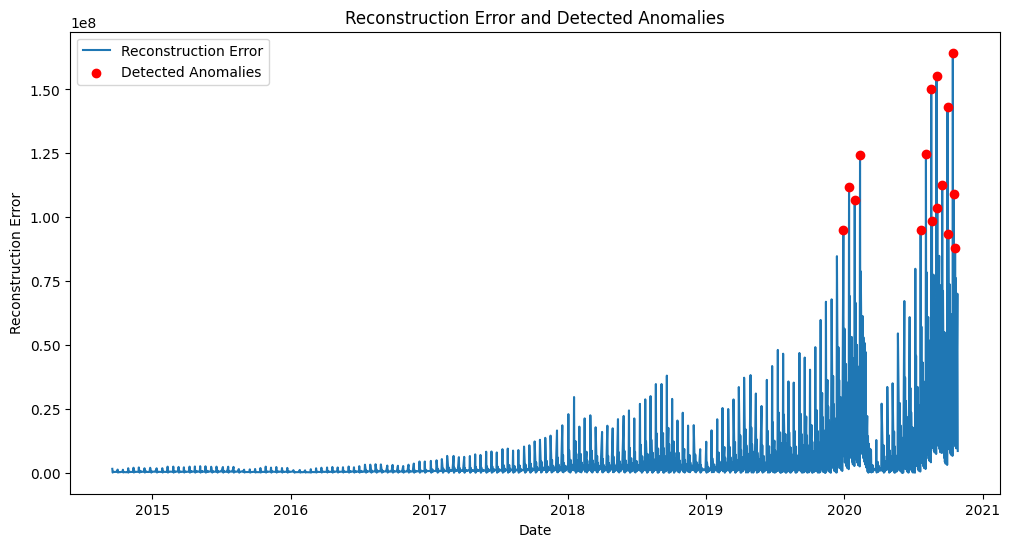

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# date_range = pd.date_range(start='2014-09-17', periods=len(reconstruction_errors), freq='B')
# date_range = pd.date_range(start='1980-01-12', periods=len(reconstruction_errors))
anomaly_indices = np.where(anomalies)
truncated_dates = test_df['Date'][:1540]

# reconstruction error over time
plt.figure(figsize=(12, 6))
plt.plot(truncated_dates, reconstruction_errors, label='Reconstruction Error')



#  detected anomalies
plt.scatter(truncated_dates.iloc[anomaly_indices], reconstruction_errors[anomaly_indices],
            color='red', label='Detected Anomalies', zorder=3)

plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error and Detected Anomalies')
plt.legend()
plt.show()


In [60]:
# model.save('saved_models/final_model')

In [61]:
anomaly_indices = np.where(anomalies)

# Get the dates of the detected anomalies using the indices
anomaly_dates = test_df['Date'].iloc[anomaly_indices]

# Print the dates of the detected anomalies
print("Detected Anomalies Dates:")
print(anomaly_dates)


Detected Anomalies Dates:
23107   2019-12-30
23117   2020-01-14
23127   2020-01-29
23137   2020-02-12
23247   2020-07-21
23257   2020-08-04
23267   2020-08-18
23269   2020-08-20
23277   2020-09-01
23279   2020-09-03
23287   2020-09-16
23297   2020-09-30
23299   2020-10-02
23307   2020-10-14
23309   2020-10-16
23311   2020-10-20
Name: Date, dtype: datetime64[ns]


In [62]:
import pandas as pd
import numpy as np

test_df['Date'] = pd.to_datetime(test_df['Date'])
anomaly_dates = pd.to_datetime(anomaly_dates)

# Create a binary array for anomaly flags
# Use list comprehension for efficiency and directly compare dates
anomaly_flags = test_df['Date'].isin(anomaly_dates).astype(int)

# Add the anomaly_flags as a new column in the DataFrame
test['Anomaly'] = anomaly_flags

# Check the results
print(test['Anomaly'])


21777    0
21778    0
21779    0
21780    0
21781    0
        ..
23318    0
23319    0
23320    0
23321    0
23322    0
Name: Anomaly, Length: 1546, dtype: int64


In [63]:
test

,Date,Open,High,Low,Close,Anomaly
21777,2014-09-17,1999.300049,2010.739990,1993.290039,2001.569946,0
21778,2014-09-18,2003.069946,2012.339966,2003.069946,2011.359985,0
21779,2014-09-19,2012.739990,2019.260010,2006.589966,2010.400024,0
21780,2014-09-22,2009.079956,2009.079956,1991.010010,1994.290039,0
21781,2014-09-23,1992.780029,1995.410034,1982.770020,1982.770020,0
...,...,...,...,...,...,...
23318,2020-10-29,3277.169922,3341.050049,3259.820068,3310.110107,0
23319,2020-10-30,3293.590088,3304.929932,3233.939941,3269.959961,0
23320,2020-11-02,3296.199951,3330.139893,3279.739990,3310.239990,0
23321,2020-11-03,3336.250000,3389.489990,3336.250000,3369.159912,0


In [64]:
test = test.reset_index()
test['Batch_ID'] = test.index // 10

In [65]:
test.tail(70)

,index,Date,Open,High,Low,Close,Anomaly,Batch_ID
1476,23253,2020-07-29,3227.219971,3264.739990,3227.219971,3258.439941,0,147
1477,23254,2020-07-30,3231.760010,3250.919922,3204.129883,3246.219971,0,147
1478,23255,2020-07-31,3270.449951,3272.169922,3220.260010,3271.120117,0,147
1479,23256,2020-08-03,3288.260010,3302.729980,3284.530029,3294.610107,0,147
1480,23257,2020-08-04,3289.919922,3306.840088,3286.370117,3306.510010,1,148
...,...,...,...,...,...,...,...,...
1541,23318,2020-10-29,3277.169922,3341.050049,3259.820068,3310.110107,0,154
1542,23319,2020-10-30,3293.590088,3304.929932,3233.939941,3269.959961,0,154
1543,23320,2020-11-02,3296.199951,3330.139893,3279.739990,3310.239990,0,154
1544,23321,2020-11-03,3336.250000,3389.489990,3336.250000,3369.159912,0,154


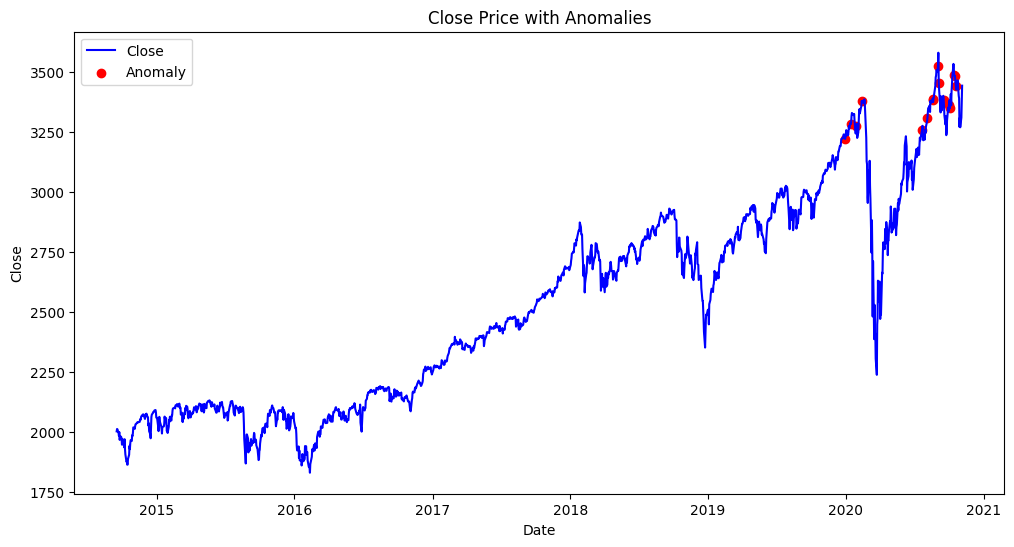

In [66]:
df = test
df['Date'] = pd.to_datetime(df['Date'])
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close', color='blue')

# Plot the anomalies (where Anomaly == 1) as red points
anomalies = df[df['Anomaly'] == 1]
plt.scatter(anomalies['Date'], anomalies['Close'], color='red', label='Anomaly')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Close Price with Anomalies')
plt.legend()

# Show the plot
plt.show()

In [67]:
np.where(anomalies)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,
         2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
         6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
         8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
        10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
        12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14,
        14, 15, 15, 15, 15, 15, 15, 15, 15]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5,
        6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3,
        4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1,
        2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5,
        6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4,

In [68]:
np.sum(scores[153][0])

1.0

In [69]:
sns.heatmap(scores[132], cmap='Purples', annot=True)

plt.title('Attention Score Heat Map')
plt.xlabel('Input Index')
plt.ylabel('Output Index')

plt.show()

NameError: name 'sns' is not defined

In [ ]:
sns.heatmap(scores[30], cmap='Purples', annot=True)

plt.title('Attention Score Heat Map')
plt.xlabel('Input Index')
plt.ylabel('Output Index')

plt.show()

In [ ]:
import numpy as np
from scipy.special import rel_entr  # Relative entropy function for KL Divergence

prob1 = scores[153][4]
prob1 /= prob1.sum()

prob2 = scores[66][4]
prob2 /= prob2.sum()

# Calculate KL Divergence
kl_divergence = np.sum(rel_entr(prob1, prob2))
print(f"KL Divergence: {kl_divergence}")

In [ ]:
def visualize_anomalies(input_sequence, reconstruction, attention_scores):
    mse = np.mean((input_sequence - reconstruction)**2, axis=2)  # Average over features
    threshold = np.percentile(mse, 95)
    anomalies = mse > threshold
    anomaly_indices = np.where(anomalies)
    print(anomaly_indices)



    num_anomalies = len(anomaly_indices[0])
    if num_anomalies > 0:
        for i in range(8):
            batch_idx, time_idx = anomaly_indices[0][i], anomaly_indices[1][i]


            plt.figure(figsize=(12, 6))
            plt.plot(input_sequence[batch_idx, time_idx, :], label='Input')
            plt.plot(reconstruction[batch_idx, time_idx, :], label='Reconstruction', linestyle='--')
            plt.scatter([time_idx], [input_sequence[batch_idx, time_idx, np.argmax(mse[batch_idx, time_idx])]], color='red')
            plt.legend()
            plt.title(f"Anomaly in Batch {batch_idx}, Time {time_idx}")
            plt.xlabel('Time Steps')
            plt.ylabel('Features')
            plt.show()


            # Attention scores for the specific time_idx across all 7 input timesteps
            plt.figure(figsize=(10, 4))
            sns.heatmap(attention_scores[batch_idx, :, :], cmap='Blues', annot=True)
            plt.title(f"Attention Scores for Batch {batch_idx}, Time {time_idx}")
            plt.xlabel('Input Timesteps')
            plt.ylabel('Output Timesteps')
            plt.show()
            #Extract attention scores for the specified point


            # attention_scores_point = attention_scores[batch_idx, time_idx, :]
            # # Plot the heatmap
            # plt.figure(figsize=(8, 6))
            # plt.imshow(attention_scores_point.reshape(1, -1), cmap='viridis', aspect='auto', vmin=0, vmax=1)
            # plt.xlabel('Input Sequence Index')
            # plt.ylabel('Point of Interest (Batch {}, Time {})'.format(batch_idx, time_idx))
            # plt.title('Attention Scores for Point of Interest')
            # plt.colorbar()
            # plt.show()


    else:
        print("No anomalies detected based on the threshold.")


# Example usage
visualize_anomalies(X_test, reconstructions, scores)





In [ ]:
print('Anomaly Indices', anomaly_dates.iloc[2])

In [70]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=4bef52ed09446b5a0489eb80a15b1e43c476a11bb8497f7ea3d302db9b941808
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
X_test.shape

In [72]:
from lime import lime_tabular

def calculate_threshold(scores, percentile=98):
    return np.percentile(scores, percentile)

def model_predict_proba(X):
    print(f'Received X is : {X.shape}')
    #X= np.expand_dims(X, axis=-1)
    X = X.reshape(-1, 10, 1)
    print(f'X after dimension expansion is : {X.shape}')
    reconstructed_X, _, _ = model.predict(X)
    print(f'X_reconstructed shape is : {len(reconstructed_X)}')
    scores = np.mean(np.square(X - reconstructed_X), axis=(1,2))
    print(f'shape of score is:{scores.shape}')
    predictions = scores > calculate_threshold(scores, 98.5)
    print(f'shape of prediction is : {predictions.shape}')
    proba = np.vstack([1 - predictions, predictions]).T
    print(f'proba shape is : {proba.shape}')
    print(f'predictions for a index is : {predictions[3]} and proba for the same index is {proba[3]}')
    return proba

#model_predict_proba(X_train)
x_train_shapes = X_train.shape
print(f'X_train[3] shape is {X_train[3].shape}')
print(f'Shape of input X is : {X_train.shape}')

print(f'shape of restructed input is : {np.array(X_train).reshape(x_train_shapes[0] * x_train_shapes[1], x_train_shapes[2]).shape}')

explainer = lime_tabular.LimeTabularExplainer(
    #training_data=np.array(X_train).reshape(x_train_shapes[0] * x_train_shapes[1], x_train_shapes[2]),
    #feature_names=['Close'],
    training_data=np.array(X_test).reshape(-1, sequence_length),
    feature_names=['time_step_{}'.format(i) for i in range(sequence_length)],  # Using timesteps as feature
    class_names=['Not Anamoly', 'Anamoly'],
    mode='classification',
    discretize_continuous=False
)

# Choose an instance to explain
i = 20
# 2020-08-04
print("Instance shape for LIME:", X_test[3].flatten())
exp = explainer.explain_instance(data_row=X_test[123].flatten(), predict_fn=model_predict_proba)

# Show the explanation
exp.show_in_notebook(show_table=True, show_all=True)

X_train[3] shape is (10, 1)
Shape of input X is : (875, 10, 1)
shape of restructed input is : (8750, 1)
Instance shape for LIME: [0.98669283 0.99316051 1.0054151  1.00528942 1.00229905 1.00830588
 1.01230695 1.01267882 1.01599906 1.01674274]
Received X is : (5000, 10)
X after dimension expansion is : (5000, 10, 1)
157/157 [==============================] - 3s 16ms/step
X_reconstructed shape is : 5000
shape of score is:(5000,)
shape of prediction is : (5000,)
proba shape is : (5000, 2)
predictions for a index is : False and proba for the same index is [1 0]
